In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('nyc_data.csv')

lat_col = df.columns[4]  # latitude is the 5th column
lon_col = df.columns[5]  # longitude is the 6th column

# Group by longitude and latitude and count occurrences
duplicate_counts = df.groupby([lat_col, lon_col]).size().reset_index(name="count")
# Filter to only show locations with more than 1 occurrence
duplicates = duplicate_counts[duplicate_counts['count'] > 1]

# Sort by count in descending order
duplicates = duplicates.sort_values('count', ascending=False)

print(f"Found {len(duplicates)} locations with duplicate entries:")
print(duplicates)

Found 23389 locations with duplicate entries:
       40.71981038  -74.00258103  count
22815    40.750795    -73.993576   1147
23675    40.752806    -73.977175    874
2980     40.645089    -73.784523    687
25633    40.757221    -73.991547    562
31127    40.773839    -73.871220    561
...            ...           ...    ...
18971    40.740900    -74.063460      2
18959    40.740884    -73.994122      2
18955    40.740876    -73.999290      2
18954    40.740874    -73.987563      2
18952    40.740873    -74.005330      2

[23389 rows x 3 columns]


In [6]:
# Filter data for a specific location
# Using one of the locations with high check-in counts from the duplicates DataFrame
target_lat = 40.750795
target_lon = -73.993576

# Allow for some small variation in coordinates (within ~10 meters)
tolerance = 0.0001

# Filter the data
filtered_data = df[
    (df[lat_col].between(target_lat - tolerance, target_lat + tolerance)) & 
    (df[lon_col].between(target_lon - tolerance, target_lon + tolerance))
]

# Save to new CSV file
filtered_data.to_csv('filtered_location_data.csv', index=False)

print(f"Found {len(filtered_data)} records for location (lat={target_lat}, lon={target_lon})")
print(f"Data saved to filtered_location_data.csv")

Found 1156 records for location (lat=40.750795, lon=-73.993576)
Data saved to filtered_location_data.csv


c:\Users\cbassem\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\cbassem\AppData\Local\Temp\ipykernel_22072\3802657395.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[ts_col] = pd.to_datetime(data[ts_col], errors="coerce")
C:\Users\cbassem\AppData\Local\Temp\ipykernel_22072\3802657395.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["_period"] = data[ts_col].dt.to_period("D").dt.to_timestamp()
17:21:03 - cmdstanpy - INFO - Chain [1] start processing
17:21:04 - cmdstanpy - INFO - Chain [1] done processing


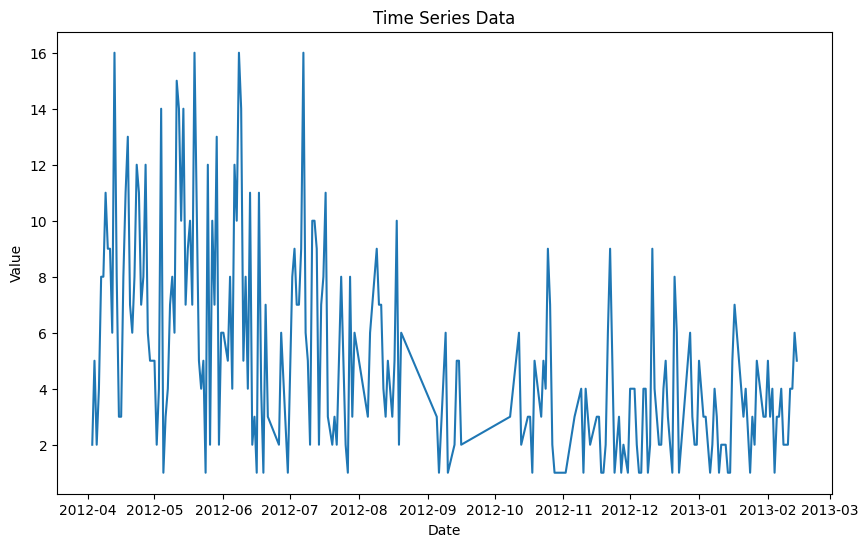

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

data = pd.read_csv('filtered_location_data.csv')
ts_col = data.columns[7]
data[ts_col] = pd.to_datetime(data[ts_col], errors="coerce")

data["_period"] = data[ts_col].dt.to_period("D").dt.to_timestamp()
grouped = data.groupby(["_period"]).size().rename("count").reset_index()

# Initialize the model
model = Prophet()

# Fit the model
# model.fit(grouped.rename(columns={"_period": "ds", "count": "y"}))

# Create future dates dataframe 
future = model.make_future_dataframe(periods=20) # 90 days into the future, depends on your choice

# Make predictions 
forecast = model.predict(future) 

# View the forecast 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

plt.figure(figsize=(10, 6))
plt.plot(grouped["_period"], grouped["count"])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

C:\Users\cbassem\AppData\Local\Temp\ipykernel_17732\2593786689.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[ts_col] = pd.to_datetime(data[ts_col], errors="coerce")
C:\Users\cbassem\AppData\Local\Temp\ipykernel_17732\2593786689.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["_period"] = data[ts_col].dt.to_period("D").dt.to_timestamp()


Root Mean Squared Error: 2.482001268243581


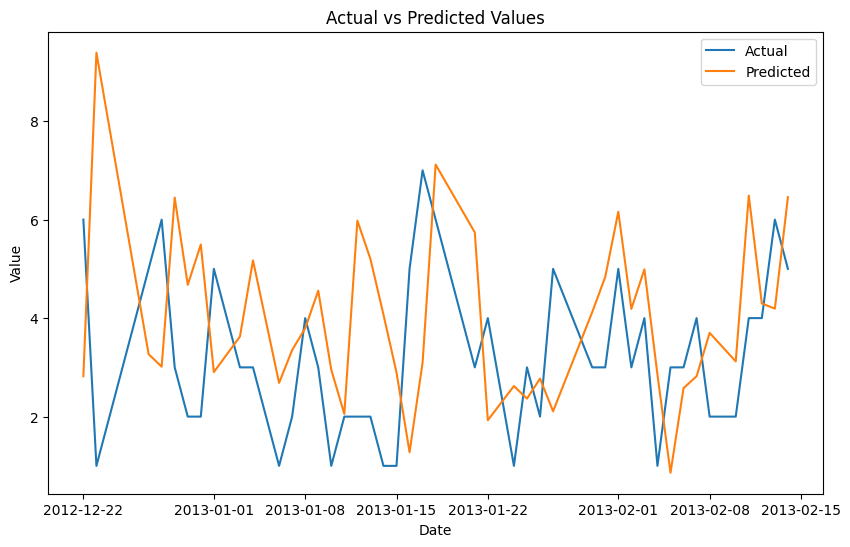

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
data = pd.read_csv('filtered_location_data.csv')
data = pd.read_csv('filtered_location_data.csv')
ts_col = data.columns[7]
data[ts_col] = pd.to_datetime(data[ts_col], errors="coerce")

data["_period"] = data[ts_col].dt.to_period("D").dt.to_timestamp()
grouped = data.groupby(["_period"]).size().rename("count").reset_index()
grouped.set_index('_period', inplace=True)

# Create lag features
def create_lag_features(df, lags, target_col):
  for lag in range(1, lags + 1):
    df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
  df.dropna(inplace=True)
  return df

grouped = create_lag_features(grouped, lags=10, target_col='count')
# Split data into features and target
X = grouped.drop(columns=['count'])
y = grouped['count']

# Split data into train and test sets
train_size = int(len(grouped) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# print (X_train)# Initialize the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()